In [174]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
from astropy.table import Table
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Smooth,Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared,Calzetti

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


In [2]:
goodss_125 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
goodsn_125 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()

In [3]:
v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

v4Ncat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Catalog/goodsn_3dhst.v4.4.cat',
                 format='ascii').to_pandas()
v4Scat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Catalog/goodss_3dhst.v4.4.cat',
                 format='ascii').to_pandas()

v4N['use'] = v4Ncat['use_phot']
v4S['use'] = v4Scat['use_phot']

v4N['star'] = v4Ncat['class_star']
v4S['star'] = v4Scat['class_star']

v4N['f125'] = v4Ncat['f_F125W']
v4S['f125'] = v4Scat['f_F125W']

In [64]:
GS_fields = ['ERSPRIME', 'GS1', 'GS2', 'GS3', 'GS4', 'GS5',]

gs_targets = []
gs_targets_z = []
gs_targets_f = []

for field in GS_fields:
    dat = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/{0}_lines_grizli.fits'.format(field)),
                     format = 'fits').to_pandas()

    dat['delta_z'] = (dat.z_84 - dat.z_16)/(1+dat.z_50)

    gs_targets.extend(dat.query('delta_z < 0.001 and 1 < z_50 < 1.5 and Ha_FLUX > 0').ID.values)
    gs_targets_z.extend(dat.query('delta_z < 0.001 and 1 < z_50 < 1.5 and Ha_FLUX > 0').z_50.values)
    gs_targets_f.extend(np.repeat(field,len(dat.query('delta_z < 0.001 and 1 < z_50 < 1.5 and Ha_FLUX > 0').z_50.values)))
    
    
GN_fields = ['GN1', 'GN2', 'GN3', 'GN4', 'GN5', 'GN7']

gn_targets = []
gn_targets_z = []
gn_targets_f = []

for field in GN_fields:
    dat = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/{0}_lines_grizli.fits'.format(field)),
                     format = 'fits').to_pandas()

    dat['delta_z'] = (dat.z_84 - dat.z_16)/(1+dat.z_50)

    gn_targets.extend(dat.query('delta_z < 0.001 and 1 < z_50 < 1.5 and Ha_FLUX > 0').ID.values)
    gn_targets_z.extend(dat.query('delta_z < 0.001 and 1 < z_50 < 1.5 and Ha_FLUX > 0').z_50.values)    
    gn_targets_f.extend(np.repeat(field,len(dat.query('delta_z < 0.001 and 1 < z_50 < 1.5 and Ha_FLUX > 0').z_50.values)))
    

In [33]:
S1_target = np.zeros(len(v4S))

v4S['S1_target'] = S1_target

for i in v4S.index:
    if v4S.id[i] in gs_targets:
        v4S['S1_target'][i] = 1 


S1_target = np.zeros(len(v4N))

v4N['S1_target'] = N1_target

for i in v4N.index:
    if v4N.id[i] in gn_targets:
        v4N['S1_target'][i] = 1 

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [39]:
v4S_S1 = v4S.query('S1_target == 1')
v4N_S1 = v4N.query('S1_target == 1')

In [65]:
z_grizli = np.repeat(-99.0, len(v4S_S1))
v4S_S1['zgrizli'] = z_grizli
field = np.repeat('---', len(v4S_S1))
v4S_S1['field'] = field


for i in v4S_S1.index:
    for ii in range(len(gs_targets_z)):
        if v4S_S1.id[i] == gs_targets[ii]:
            v4S_S1['zgrizli'][i] = gs_targets_z[ii]
            v4S_S1['field'][i] = gs_targets_f[ii]
            
z_grizli = np.repeat(-99.0, len(v4N_S1))
v4N_S1['zgrizli'] = z_grizli
field = np.repeat('---', len(v4N_S1))
v4N_S1['field'] = field

for i in v4N_S1.index:
    for ii in range(len(gn_targets_z)):
        if v4N_S1.id[i] == gn_targets[ii]:
            v4N_S1['zgrizli'][i] = gn_targets_z[ii]
            v4N_S1['field'][i] = gn_targets_f[ii]            

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

In [49]:
def IR_prime(n, Reff, R):
    b = 2*n - (1/3)  
    return R * np.exp(-b * (R / Reff)**(1/n))

def Sigma_1(field, galaxy):
    if field[1] == 'N':
        main_cat = v4N_S1
        mass = main_cat.query('id == {0}'.format(galaxy)).mass.values[0]
        zphot = main_cat.query('id == {0}'.format(galaxy)).zgrizli.values[0] 
        flux = main_cat.query('id == {0}'.format(galaxy)).f125.values[0]
        gfit_cat = goodsn_125

    else:
        main_cat = v4S_S1
        mass = main_cat.query('id == {0}'.format(galaxy)).mass.values[0]
        zphot = main_cat.query('id == {0}'.format(galaxy)).zgrizli.values[0] 
        flux = main_cat.query('id == {0}'.format(galaxy)).f125.values[0]
        gfit_cat = goodss_125

    grow = gfit_cat.query('NUMBER == {0}'.format(galaxy))

    Reff = (grow.re.values[0] * np.sqrt(grow.q.values[0])) * (cosmo.kpc_proper_per_arcmin(zphot).value)/60
    n = grow.n.values[0]
    mgal = grow.mag.values[0]    

    r_range = np.linspace(0,1,1000)
    top = np.trapz(IR_prime(n, Reff, r_range), r_range)

    r_range = np.linspace(0,100,100000)
    bottom = np.trapz(IR_prime(n, Reff, r_range), r_range)   

    Lgal = 10**((mgal + 48.6) / -2.5)   
    Mab = -2.5*np.log10(flux) + 25
    Lez = 10**((Mab + 48.6) / -2.5) 

    return np.log10((top / bottom)*(Lgal / Lez)*mass / np.pi**2)

In [53]:
S1 = np.repeat(-99.0, len(v4S_S1))
v4S_S1['S1'] = S1
for i in v4S_S1.index:
    v4S_S1['S1'][i] = Sigma_1('GSD', v4S_S1.id[i])
    
S1 = np.repeat(-99.0, len(v4N_S1))
v4N_S1['S1'] = S1
for i in v4N_S1.index:
    v4N_S1['S1'][i] = Sigma_1('GND', v4N_S1.id[i])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [55]:
v4S_S1.query('S1 > 9.5')

,id,ra,dec,z_spec,nusefilt,lc_min,lc_max,numpeaks,z_phot,z_phot_chi2,...,rest162,rest162_err,rest163,rest163_err,use,star,f125,S1_target,zgrizli,S1
26913,26914,53.121724,-27.785436,0.668,40,3686.439741,79157.486154,1,0.670742,89.094414,...,263.950547,3.210250,198.551871,2.470031,1,0.03,103.362619,1.0,1.035477,9.550598
30975,30976,53.162853,-27.767157,1.221,39,3686.439741,79157.486154,1,2.734124,1766.759172,...,231.874707,2.488079,270.389191,2.043232,1,0.52,54.709926,1.0,1.221045,9.984523
39169,39170,53.041826,-27.725868,1.022,38,3686.439741,79157.486154,1,1.034528,399.686156,...,219.593307,3.072619,168.426946,1.691739,1,0.03,73.833945,1.0,1.022993,9.877416
42112,42113,53.151174,-27.713724,-1.000,38,3686.439741,79157.486154,1,1.695305,132.488580,...,104.277974,0.326264,78.297258,0.858939,1,0.53,22.229478,1.0,1.415603,10.134377
43265,43266,53.142836,-27.706936,1.088,38,3686.439741,79157.486154,1,1.108559,140.218677,...,198.908446,3.267670,157.448499,1.254144,1,0.03,63.541782,1.0,1.091921,9.578276


In [56]:
v4N_S1.query('S1 > 9.5')

,id,ra,dec,z_spec,nusefilt,lc_min,lc_max,numpeaks,z_phot,z_phot_chi2,...,rest162,rest162_err,rest163,rest163_err,use,star,f125,S1_target,zgrizli,S1
24220,24221,189.377772,62.261030,0.0,21,3592.809617,79157.486154,1,0.856939,12892.811788,...,94.694646,0.288079,81.294822,0.228390,0,0.99,180.879917,1.0,1.476900,10.018472
37737,37738,189.281185,62.363288,-1.0,19,3592.809617,79157.486154,1,1.549406,253.786687,...,120.124039,2.468068,146.202738,1.249417,1,0.92,41.781066,1.0,1.450711,9.693630


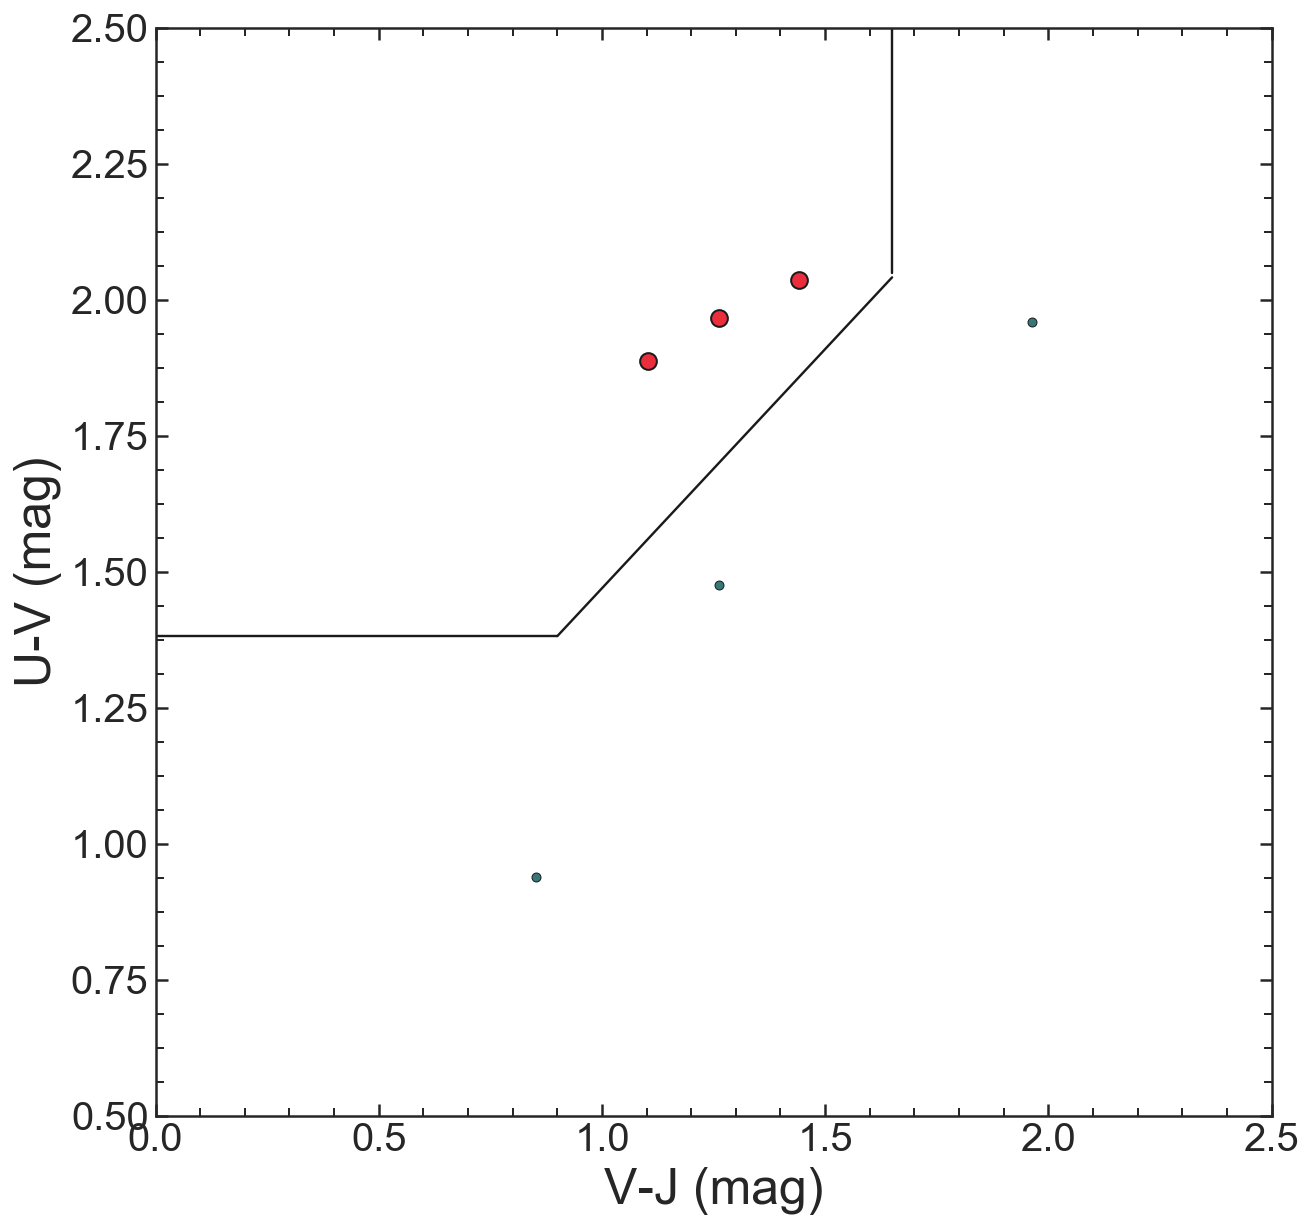

In [58]:
def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

NUV = Color(v4N_S1.query('S1 > 9.5').restU, v4N_S1.query('S1 > 9.5').restV)
NVJ = Color(v4N_S1.query('S1 > 9.5').restV, v4N_S1.query('S1 > 9.5').restJ)
SUV = Color(v4S_S1.query('S1 > 9.5').restU, v4S_S1.query('S1 > 9.5').restV)
SVJ = Color(v4S_S1.query('S1 > 9.5').restV, v4S_S1.query('S1 > 9.5').restJ)

SQ = []
NQ = []
Ssf = []
Nsf = []
for i in NUV.index:
    if NUV[i]>=0.88*NVJ[i]+0.59 and NUV[i]>1.382 and NVJ[i]<1.65:
        NQ.append(i)
    else:
        Nsf.append(i)
    
for i in SUV.index:
    if SUV[i]>=0.88*SVJ[i]+0.59 and SUV[i]>1.382 and SVJ[i]<1.65:
        SQ.append(i)
    else:
        Ssf.append(i)
    
plt.figure(figsize=[10,10])
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0.1, light=1.1, as_cmap=True)

plt.scatter(SVJ[Ssf], SUV[Ssf],marker = 'o', s=20, color = '#36787A',linewidths=0.5, edgecolors='k')
plt.scatter(NVJ[Nsf], NUV[Nsf],marker = 'o', s=20, color = '#36787A',linewidths=0.5, edgecolors='k')

plt.scatter(SVJ[SQ], SUV[SQ],marker = 'o', s=70, color = '#EA2E3B',linewidths=1, edgecolors='k')
plt.scatter(NVJ[NQ], NUV[NQ],marker = 'o', s=70, color = '#EA2E3B',linewidths=1, edgecolors='k')

plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
plt.axis([0,2.5,.5,2.5])

plt.xlabel('V-J (mag)', fontsize=25)
plt.ylabel('U-V (mag)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

In [67]:
for i in Ssf:
    print(v4S_S1.field[i],v4S_S1.id[i], v4S_S1.S1[i])
    
for i in Nsf:
    print(v4N_S1.field[i],v4N_S1.id[i], v4N_S1.S1[i])

GS4 30976 9.984523252080404
GS3 43266 9.578275893126547
GN4 24221 10.018471934241553
GN1 37738 9.693629925441105


# Extract beams and gather data

In [68]:
Grism_flts = glob('/Volumes/Vince_CLEAR/Data/Grism_fields/GN1/*GrismFLT.fits')

grp = multifit.GroupFLT(grism_files = Grism_flts, verbose=False)

Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/ib3720f4q.01.GrismFLT.fits!
Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/ib3720f0q.01.GrismFLT.fits!
Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/ib3720fgq.01.GrismFLT.fits!
Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/ib3720fkq.01.GrismFLT.fits!


Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/icat20tdq.01.GrismFLT.fits!


Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/icat20tiq.01.GrismFLT.fits!


Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/icat20tpq.01.GrismFLT.fits!


Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/icat20tuq.01.GrismFLT.fits!


Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/icxt46swq.01.GrismFLT.fits!
Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/icxt46sxq.01.GrismFLT.fits!
Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/icxt46t0q.01.GrismFLT.fits!
Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/icxt46t2q.01.GrismFLT.fits!
Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/icxt47xbq.01.GrismFLT.fits!
Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/icxt47xcq.01.GrismFLT.fits!
Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/icxt47xfq.01.GrismFLT.fits!
Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/icxt47xhq.01.GrismFLT.fits!
Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/icxt48mgq.01.GrismFLT.fits!
Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/icxt48mhq.01.GrismFLT.fits!
Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/icxt48mnq.01.GrismFLT.fits!
Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/icxt48mtq.01.GrismFLT.fits!
Load /Volumes/Vince_CLEAR/Data/Grism_fields/GN1/icxt49hmq.01.GrismFLT.fits!
Load /Volume

In [70]:
beams = grp.get_beams(37738)

In [72]:
pa = -1
idx = 0
for BEAM in beams:
    if pa != BEAM.get_dispersion_PA():
        print('Instrument : {0}, ORIENT : {1}'.format(BEAM.grism.filter,BEAM.get_dispersion_PA()),idx)
        pa = BEAM.get_dispersion_PA()
    idx += 1

Instrument : G141, ORIENT : 142.0 0
Instrument : G102, ORIENT : 129.0 4
Instrument : G102, ORIENT : 109.0 12
Instrument : G102, ORIENT : 169.0 20


In [74]:
# save out G102 - 129
BEAM = beams[4]
BEAM.write_fits(root='../CLEAR_show_and_tell/129', clobber=True)
fits.setval('../CLEAR_show_and_tell/129_37738.g102.A.fits', 'EXPTIME', ext=0,
        value=fits.open('../CLEAR_show_and_tell/129_37738.g102.A.fits')[1].header['EXPTIME'])   

# save out G102 - 109
BEAM = beams[12]
BEAM.write_fits(root='../CLEAR_show_and_tell/109', clobber=True)
fits.setval('../CLEAR_show_and_tell/109_37738.g102.A.fits', 'EXPTIME', ext=0,
        value=fits.open('../CLEAR_show_and_tell/109_37738.g102.A.fits')[1].header['EXPTIME'])   

# save out G102 - 169
BEAM = beams[20]
BEAM.write_fits(root='../CLEAR_show_and_tell/169', clobber=True)
fits.setval('../CLEAR_show_and_tell/169_37738.g102.A.fits', 'EXPTIME', ext=0,
        value=fits.open('../CLEAR_show_and_tell/169_37738.g102.A.fits')[1].header['EXPTIME'])   

# save out G141 - 142
BEAM = beams[0]
BEAM.write_fits(root='../CLEAR_show_and_tell/142', clobber=True)
fits.setval('../CLEAR_show_and_tell/142_37738.g141.A.fits', 'EXPTIME', ext=0,
        value=fits.open('../CLEAR_show_and_tell/142_37738.g141.A.fits')[1].header['EXPTIME'])  

In [4]:
# ref_cat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Catalog/goodsn_3dhst.v4.4.cat',format='ascii').to_pandas()

from spec_extract import Stack

def Phot_save(field,galaxy_id,ref_cat, masterlist = '../phot/master_template_list.pkl'):
    galdf = ref_cat[ref_cat.id == galaxy_id]
    master_tmp_df = pd.read_pickle(masterlist)

    if field == 'GSD':
        pre= 'S_'

    if field == 'GND':
        pre= 'N_'

    eff_wv = []
    phot_fl = []
    phot_er = []
    phot_num = []

    for i in galdf.keys():
        if i[0:2] == 'f_':
            Clam = 3E18 / master_tmp_df.eff_wv[master_tmp_df.tmp_name == pre + i].values[0] **2 * 10**((-1.1)/2.5-29)
            if galdf[i].values[0] > -99.0:
                eff_wv.append(master_tmp_df.eff_wv[master_tmp_df.tmp_name == pre + i].values[0])
                phot_fl.append(galdf[i].values[0]*Clam)
                phot_num.append(master_tmp_df.tmp_num[master_tmp_df.tmp_name == pre + i].values[0])
        if i[0:2] == 'e_':
            if galdf[i].values[0] > -99.0:
                phot_er.append(galdf[i].values[0]*Clam)

    np.save('../CLEAR_show_and_tell/{0}_{1}_phot'.format(field, galaxy_id), [eff_wv,phot_fl,phot_er,phot_num])
    
def Extract_spec(field,galaxy_id):
    Field = field
    spec_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/{0}/*{1}*1D.fits'.format(Field, galaxy_id))

    Bwv, Bfl, Ber, Bft, Bln, Bct = [[],[],[],[],[],[]]

    Rwv, Rfl, Rer, Rft, Rln, Rct = [[],[],[],[],[],[]]

    for i in range(len(spec_list)):
        dat = fits.open(spec_list[i])

        try:
            Bwv.append(np.array(dat['G102'].data['wave']).T)
            Bfl.append(np.array(dat['G102'].data['flux']).T)
            Ber.append(np.array(dat['G102'].data['err']).T)
            Bft.append(np.array(dat['G102'].data['flat']).T)
            Bln.append(np.array(dat['G102'].data['line']).T)
            Bct.append(np.array(dat['G102'].data['cont']).T)

        except:
            print('no g102')

        try:
            Rwv.append(np.array(dat['G141'].data['wave']).T)
            Rfl.append(np.array(dat['G141'].data['flux']).T)
            Rer.append(np.array(dat['G141'].data['err']).T)
            Rft.append(np.array(dat['G141'].data['flat']).T)
            Rln.append(np.array(dat['G141'].data['line']).T)
            Rct.append(np.array(dat['G141'].data['cont']).T)

        except:
            print('no g141')

    if len(Bwv) > 0:                
        SBW, SBF, SBE, SBT, SBL, SBC = Stack(Bwv, Bfl, Ber, Bft, Bln, Bct)
        np.save('../CLEAR_show_and_tell/{0}_{1}_g102'.format(field, galaxy_id),[SBW, SBF, SBE, SBT, SBL, SBC])


    if len(Rwv) > 0:     
        SRW, SRF, SRE, SRT, SRL, SRC = Stack(Rwv, Rfl, Rer, Rft, Rln, Rct)
        np.save('../CLEAR_show_and_tell/{0}_{1}_g141'.format(field, galaxy_id),[SRW, SRF, SRE, SRT, SRL, SRC])



In [90]:
Phot_save('GND', 37738, ref_cat)
Extract_spec('GN1', 37738)

/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_extract.py:41: RuntimeWarning: divide by zero encountered in power
  weigrid = errgrid ** (-2)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_extract.py:48: RuntimeWarning: invalid value encountered in double_scalars
  stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_extract.py:49: RuntimeWarning: invalid value encountered in double_scalars
  stack_flat[i] = np.sum(fltgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_extract.py:50: RuntimeWarning: invalid value encountered in double_scalars
  stack_line[i] = np.sum(linegrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_extract.py:51: RuntimeWarning: invalid value encountered in double_scalars
  stack_cont[i] = np.sum(contgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/Vince.ec/GitHub/Cluster_and_fiel

In [6]:
from sim_engine import *

class Gen_SF_spec_2(object):
    def __init__(self, field, galaxy_id, specz,
                 g102_lims=[8200, 11300], g141_lims=[11200, 16000],
                phot_errterm = 0, irac_err = None, mask = True):
        self.field = field
        self.galaxy_id = galaxy_id
        self.specz = specz
        self.c = 3E18          # speed of light angstrom s^-1
        self.g102_lims = g102_lims
        self.g141_lims = g141_lims
        self.g102_beam = glob('../CLEAR_show_and_tell/*{0}*g102.A.*'.format(galaxy_id))
        self.g141_beam = glob('../CLEAR_show_and_tell/*{0}*g141.A.*'.format(galaxy_id))
        self.sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau = 0.1, dust_type = 1)
        self.mask = mask

        """
        B - prefix refers to g102
        R - prefix refers to g141
        P - prefix refers to photometry
        
        field - GND/GSD/UDS
        galaxy_id - ID number from 3D-HST
        specz - z_grism
        g102_lims - window for g102
        g141_lims - window for g141
        """
         
        ##load spec and phot
#         try:
        self.Bwv, self.Bwv_rf, self.Bflx, self.Berr, self.Bflt, self.IDB, self.Bline, self.Bcont = load_spec_SF_2(self.field,
                            self.galaxy_id, 'g102', self.g102_lims,  self.specz, mask = self.mask)

        self.Bfl = self.Bflx / self.Bflt 
        self.Bbeam, self.Btrans = load_beams_and_trns(self.Bwv, self.g102_beam)
        self.Ber = self.Berr / self.Bflt
        self.g102 = True
#         if self.mask == False:
#             self.Bmask = get_mask(self.field, self.galaxy_id, self.Bwv, 'g102')
                
#         except:
#             print('missing g102')
#             self.g102 = False
        
        try:
            self.Rwv, self.Rwv_rf, self.Rflx, self.Rerr, self.Rflt, self.IDR, self.Rline, self.Rcont = load_spec_SF_2(self.field,
                                self.galaxy_id, 'g141', self.g141_lims,  self.specz, mask = self.mask)

            self.Rfl = self.Rflx / self.Rflt 
            self.Rbeam, self.Rtrans = load_beams_and_trns(self.Rwv, self.g141_beam)
            self.Rer = self.Rerr / self.Rflt
            self.g141 = True
#             if self.mask == False:
#                 self.Rmask = get_mask(self.field, self.galaxy_id, self.Rwv, 'g141')

        except:
            print('missing g141')
            self.g141 = False
        
        self.Pwv, self.Pwv_rf, self.Pflx, self.Perr, self.Pnum = load_spec_SF_2(self.field,
                                self.galaxy_id, 'phot', self.g141_lims,  self.specz, grism = False)
         
        self.Perr = apply_phot_err(self.Pflx, self.Perr, self.Pnum, base_err = phot_errterm, irac_err = irac_err)
        # load photmetry precalculated values
        self.model_photDF, self.IDP, self.sens_wv, self.trans, self.b, self.dnu, self.adj, self.mdleffwv = load_phot_precalc(self.Pnum)
    
    def Sim_spec_premade(self, model_wave, model_flux):
        if self.g102:
            self.Bmfl = self.Forward_model_all_beams_flatted(self.Bbeam, self.Btrans, self.Bwv, model_wave, model_flux)
            self.Bmfl *= self.PC

            if not self.set_scale:
                Bscale = Scale_model(self.Bfl, self.Ber, self.Bmfl)

                self.Bfl = self.Bfl / Bscale ; self.Ber = self.Ber / Bscale 
                
        if self.g141: 
            self.Rmfl = self.Forward_model_all_beams_flatted(self.Rbeam, self.Rtrans, self.Rwv, model_wave, model_flux) 
            self.Rmfl *= self.PC

            if not self.set_scale:
                Rscale = Scale_model(self.Rfl, self.Rer, self.Rmfl)

                self.Rfl = self.Rfl / Rscale ; self.Rer = self.Rer / Rscale 
    
    def Sim_phot_mult(self, model_wave, model_flux):
        return forward_model_phot(model_wave, model_flux, self.IDP, self.sens_wv, self.b, self.dnu, self.adj)

    def Sim_phot_premade(self, model_wave, model_flux, scale = True):
        self.Pmfl = self.Sim_phot_mult(model_wave, model_flux)
        self.PC =  Scale_model(self.Pflx, self.Perr, self.Pmfl)
        
        if scale == False:
            self.PC = 1
            
        self.Pmfl = self.Pmfl * self.PC
    
    @staticmethod
    def Forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
        return forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux)
    
    def Sim_all_premade(self, model_wave, model_flux, scale = True):
        self.Sim_phot_premade(model_wave, model_flux, scale = scale)
        self.Sim_spec_premade(model_wave, model_flux)
        
    def Best_fit_scale(self, model_wave, model_flux, specz, bp1, rp1, massperc,logmass):
        self.Full_forward_model(model_wave, F_lam_per_M(model_flux, model_wave * (1 + specz),
                            specz, 0, massperc)*10**logmass, specz)

        if self.g102:
            self.bcal = Calibrate_grism([self.Bwv, self.Bfl, self.Ber], self.Bmfl, bp1)
#             if self.mask == False:
#                 self.bscale = Scale_model(self.Bfl[self.Bmask] / self.bcal[self.Bmask], 
#                                           self.Ber[self.Bmask]/ self.bcal[self.Bmask], self.Bmfl[self.Bmask])

#             else:
#                 self.bscale = Scale_model(self.Bfl / self.bcal, self.Ber/ self.bcal, self.Bmfl)
            self.Bfl =  self.Bfl/ self.bcal/ self.bscale
            self.Ber =  self.Ber/ self.bcal/ self.bscale
            
        if self.g141:
            self.rcal = Calibrate_grism([self.Rwv, self.Rfl, self.Rer], self.Rmfl, rp1)
#             if self.mask == False:
#                 self.rscale = Scale_model(self.Rfl[self.Rmask] / self.rcal[self.Rmask], 
#                                           self.Rer[self.Rmask]/ self.rcal[self.Rmask], self.Rmfl[self.Rmask])
                
#             else:
#                 self.rscale = Scale_model(self.Rfl / self.rcal, self.Rer/ self.rcal, self.Rmfl)
            self.Rfl =  self.Rfl/ self.rcal/ self.rscale
            self.Rer =  self.Rer/ self.rcal/ self.rscale
            
    def Full_forward_model(self, model_wave, model_flux, specz):
        
        if self.g102:
            self.Bmfl = self.Forward_model_all_beams(self.Bbeam , self.Btrans, self.Bwv, model_wave * (1 + specz), model_flux)

        if self.g141:
            self.Rmfl = self.Forward_model_all_beams(self.Rbeam , self.Rtrans, self.Rwv, model_wave * (1 + specz), model_flux)
            
        self.Pmfl = self.Sim_phot_mult(model_wave * (1 + specz), model_flux)
        
    def Best_fit_scale_flam(self, model_wave, model_flam, specz, bp1, rp1):
        self.Full_forward_model(model_wave, model_flam, specz)

        if self.g102:
            self.bcal = Calibrate_grism([self.Bwv, self.Bfl, self.Ber], self.Bmfl, bp1)
#             if self.mask == False:
#                 self.bscale = Scale_model(self.Bfl[self.Bmask] / self.bcal[self.Bmask], 
#                                           self.Ber[self.Bmask]/ self.bcal[self.Bmask], self.Bmfl[self.Bmask])

#             else:
#                 self.bscale = Scale_model(self.Bfl / self.bcal, self.Ber/ self.bcal, self.Bmfl)            
            self.Bfl =  self.Bfl/ self.bcal/ self.bscale
            self.Ber =  self.Ber/ self.bcal/ self.bscale
            
            
        if self.g141:
            self.rcal = Calibrate_grism([self.Rwv, self.Rfl, self.Rer], self.Rmfl, rp1)
#             if self.mask == False:
#                 self.rscale = Scale_model(self.Rfl[self.Rmask] / self.rcal[self.Rmask], 
#                                           self.Rer[self.Rmask]/ self.rcal[self.Rmask], self.Rmfl[self.Rmask])
                
#             else:
#                 self.rscale = Scale_model(self.Rfl / self.rcal, self.Rer/ self.rcal, self.Rmfl)
            self.Rfl =  self.Rfl/ self.rcal/ self.rscale
            self.Rer =  self.Rer/ self.rcal/ self.rscale
        
def load_spec_SF_2(field, galaxy_id, instr, lims, specz, grism = True, mask = True):
    # if loading photometry FLT stands in for num
    bfilters = [34, 36, 37, 58, 117, 118, 195, 196, 220, 224]

    if grism:
        W, F, E, FLT, L, C = np.load('../CLEAR_show_and_tell/{0}_{1}_{2}.npy'.format(field, galaxy_id, instr))
        
        IDX = [U for U in range(len(W)) if lims[0] <= W[U] <= lims[-1] and F[U]**2 > 0]

        W = np.array(W[IDX])
        WRF = np.array(W / (1 + specz))
        FLT = np.array(FLT[IDX])
        F = np.array(F[IDX]) 
        E = np.array(E[IDX]) 
        L = np.array(L[IDX]) 
        C = np.array(C[IDX]) 
        
        if mask:
            IDT = get_mask(field, galaxy_id, W, instr)
            return W[IDT], WRF[IDT], F[IDT], E[IDT], FLT[IDT], np.array(IDX)[IDT], L[IDT], C[IDT]
        
        else:
            return W, WRF, F, E, FLT, np.array(IDX), L, C

    else:
        W, F, E, FLT = np.load('../CLEAR_show_and_tell/{0}_{1}_{2}.npy'.format(field, galaxy_id, instr))
        
        WRF = W / (1 + specz)
        
        IDX = []
        
        for i in range(len(FLT)):
            if FLT[i] not in bfilters and F[i] / E[i] > 0.5:
                IDX.append(i)
        
        W, WRF, F, E, FLT = W[IDX], WRF[IDX], F[IDX], E[IDX], FLT[IDX]
        
        W, WRF, F, E, FLT = W[F > 0], WRF[F > 0], F[F > 0], E[F > 0], FLT[F > 0]
        
        return W, WRF, F, E, FLT

In [7]:
Gs = Gen_SF_spec_2('GND', 37738, 1.4507, mask = False)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


No handles with labels found to put in legend.


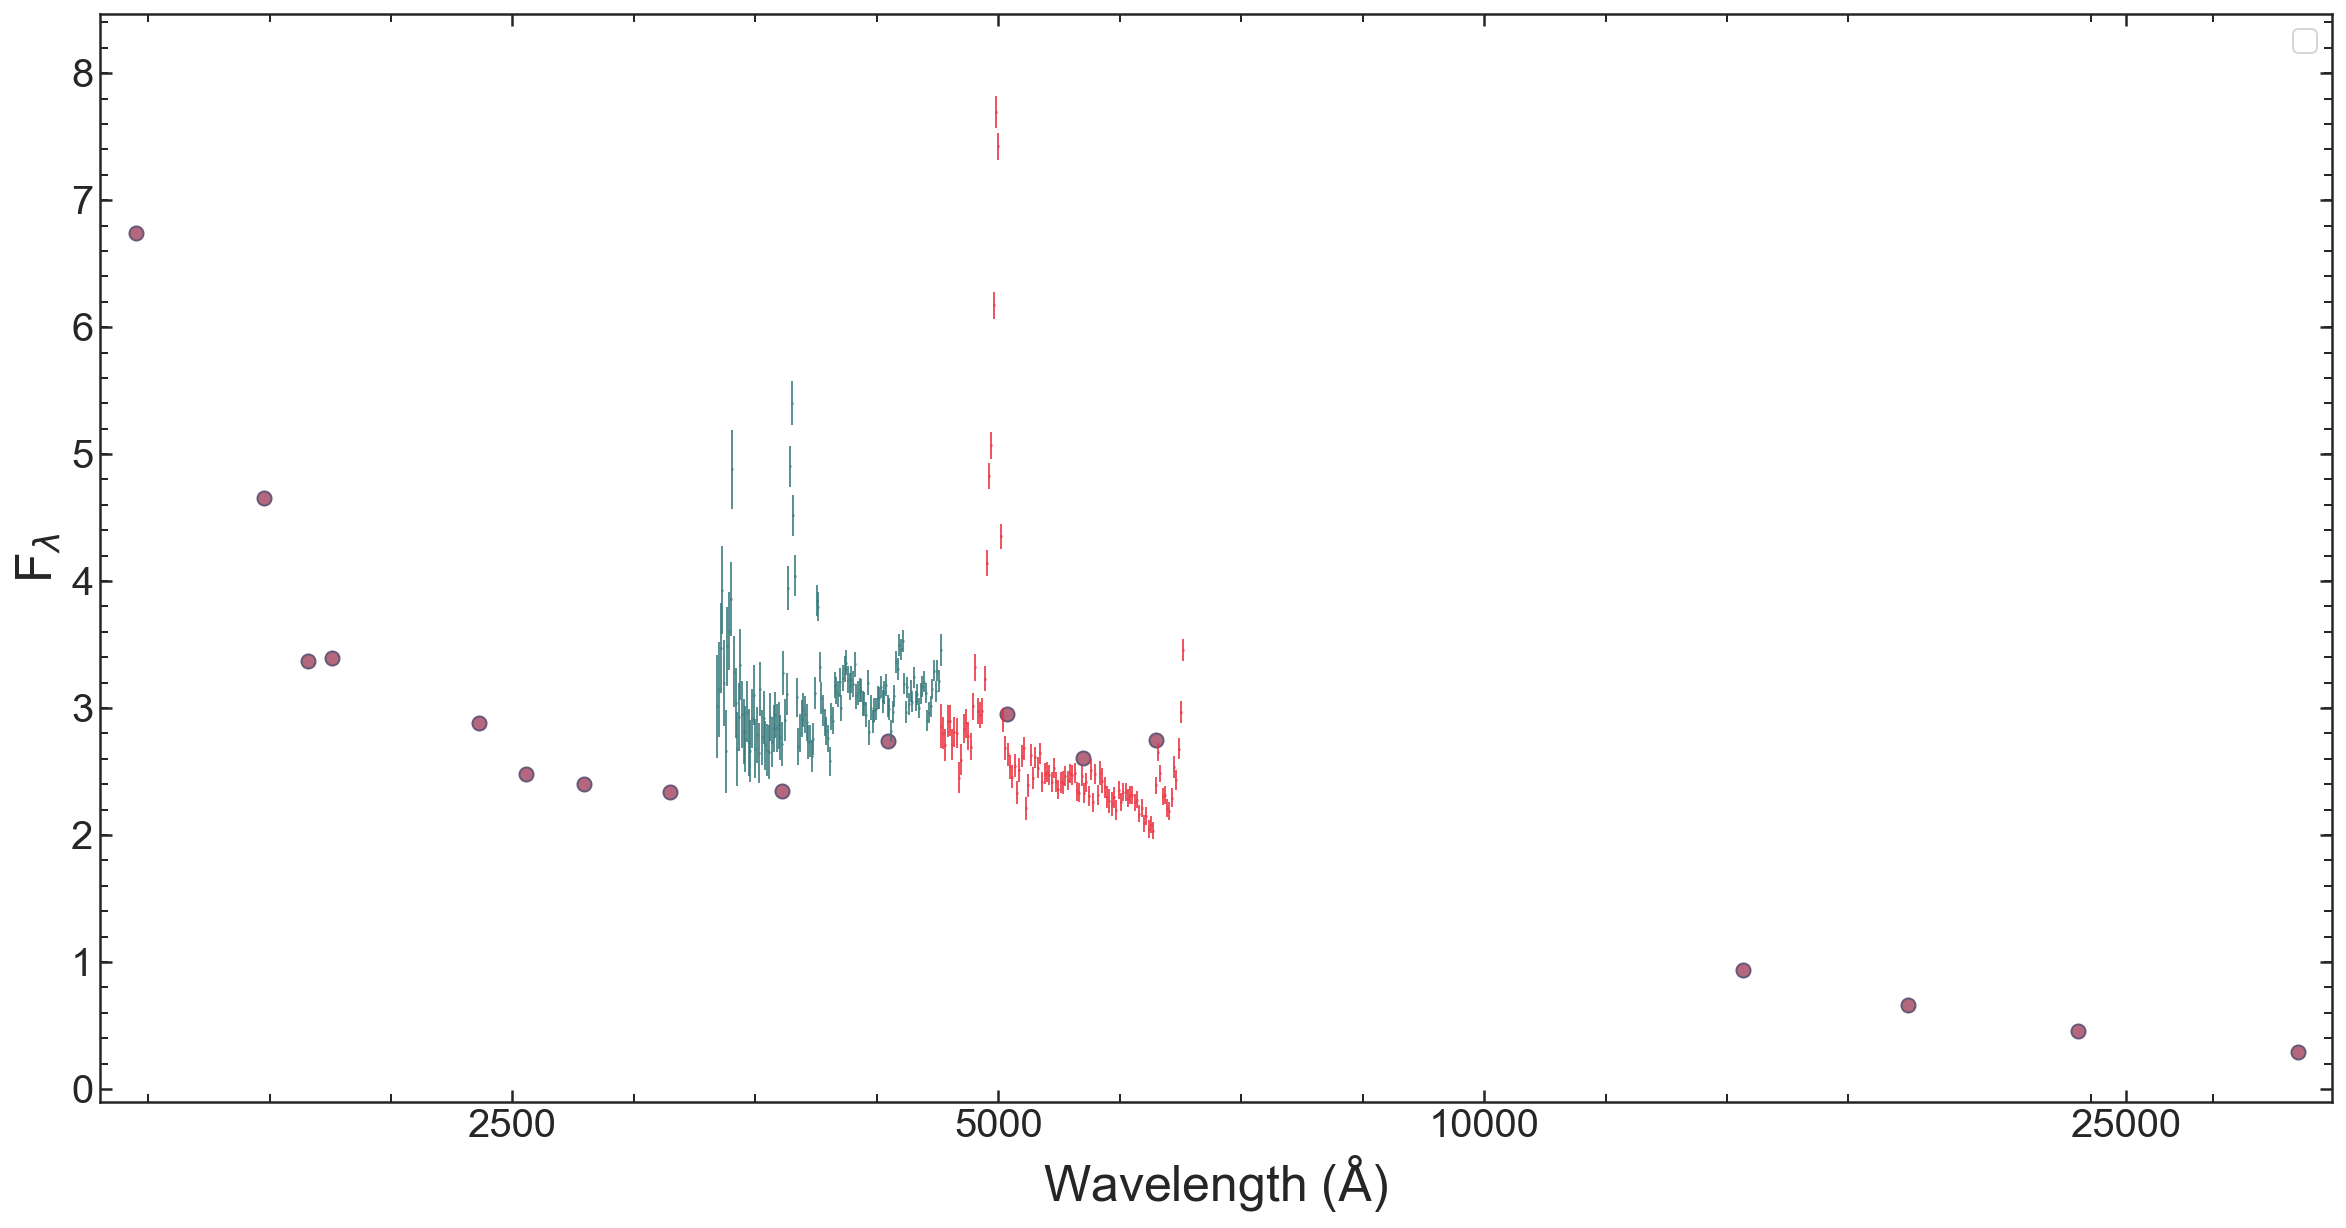

In [8]:
plt.figure(figsize=[20,10])
ax = plt.subplot()
ax.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
        linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.8)
ax.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
        linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.8)

ax.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
    linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
         markeredgecolor = '#685877',markeredgewidth = 1)

ax.set_xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))
ax.set_ylim(-0.1,max(Gs.Rfl *1E18)*1.1)

ax.set_xticks(np.log10([2500,5000,10000,25000]))
ax.set_xticklabels(np.array([2500,5000,10000,25000]))
ax.legend(fontsize=15, frameon = True, loc = 1)
ax.set_xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
ax.set_ylabel(r'F$_\lambda$', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)

In [28]:
from spec_id import *
import fsps
    
verbose=False
poolsize = 8


agelim = Oldest_galaxy(1.45)
specz = 1.45
def Galfit_prior(u):
    m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
    a = (agelim - 1)* u[1] + 1
        
    tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7]])
    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)
    m1, m2, m3, m4, m5, m6 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a, binnum = 6))
    
    lm = Gaussian_prior(u[8], [9.5, 11.5], 11, 0.75)
     
    d = 4*u[9]
    
    bp1 = Gaussian_prior(u[10], [-0.1,0.1], 0, 0.05)
    rp1 = Gaussian_prior(u[11], [-0.05,0.05], 0, 0.025)
    
    ba = log_10_prior(u[12], [0.1,10])
    bb = log_10_prior(u[13], [0.0001,1])
    bl = log_10_prior(u[14], [0.01,1])
    
    ra = log_10_prior(u[15], [0.1,10])
    rb = log_10_prior(u[16], [0.0001,1])
    rl = log_10_prior(u[17], [0.01,1])
     
    glz = Gaussian_prior(u[18], [-2,2], 0.0, 1)
        
    return [m, a, m1, m2, m3, m4, m5, m6, lm, d, bp1, rp1, ba, bb, bl, ra, rb, rl, glz]

def Galfit_L(X):
    m, a, m1, m2, m3, m4, m5, m6, lm, d, bp1, rp1, ba, bb, bl, ra, rb, rl,glz = X
    
    sp.params['dust2'] = d
    sp.params['logzsol'] = np.log10(m)
    sp.params['gas_logz'] = glz

    time, sfr, tmax = convert_sfh(get_agebins(a, binnum = 6), [m1, m2, m3, m4, m5, m6], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr) 
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux,wave*(1 + specz), specz, 0, sp.stellar_mass)*10**lm, specz, 
                                    wvs, flxs, errs, beams, trans)
       
    Gmfl = Full_calibrate_2(Gmfl, [bp1, rp1], wvs, flxs, errs)
   
    return Full_fit_2(Gs, Gmfl, Pmfl, [ba,ra], [bb,rb], [bl, rl], wvs, flxs, errs)

#########define fsps#########
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
sp.params['dust1'] = 0
sp.params['add_neb_emission']=1
sp.params['gas_logz'] = -1.0
sp.params['gas_logu'] = -2.5

####generate grism items#####
wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

[0.4054073642194824, 0.2092717626783748, 0.31552630077170724, 0.4228732341598313, 0.07295913856926216, 0.06637020149942947, 0.06262137087463558, 0.059649754125134256, 10.66238408101389, 0.05382872579821285, 0.06826754690583217, 0.011284850592506132, 0.3396349578101768, 0.6721730921624185, 0.012257654086126914, 0.2347112357592162, 0.002301323012633557, 0.46448465017368273, 0.06201555035200025]


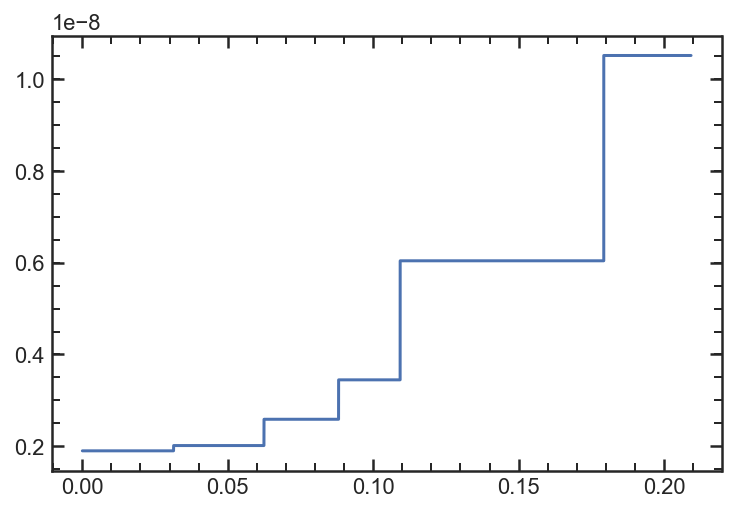

In [45]:
u = np.random.rand(19)

m = Gaussian_prior(u[0], [0.002,0.03], 0.019, 0.08)/ 0.019
a = 1* u[1] + .1

tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7]])
taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)
m1, m2, m3, m4, m5, m6 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a, binnum = 6))

lm = Gaussian_prior(u[8], [9.5, 11.5], 11, 0.75)

d = 4*u[9]

bp1 = Gaussian_prior(u[10], [-0.1,0.1], 0, 0.05)
rp1 = Gaussian_prior(u[11], [-0.05,0.05], 0, 0.025)

ba = log_10_prior(u[12], [0.1,10])
bb = log_10_prior(u[13], [0.0001,1])
bl = log_10_prior(u[14], [0.01,1])

ra = log_10_prior(u[15], [0.1,10])
rb = log_10_prior(u[16], [0.0001,1])
rl = log_10_prior(u[17], [0.01,1])

glz = Gaussian_prior(u[18], [-2,2], 0.0, 1)
        
X = [m, a, m1, m2, m3, m4, m5, m6, lm, d, bp1, rp1, ba, bb, bl, ra, rb, rl, glz]

print(X)

sp.params['dust2'] = d
sp.params['logzsol'] = np.log10(m)
sp.params['gas_logz'] = glz

time, sfr, tmax = convert_sfh(get_agebins(a, binnum = 6), [m1, m2, m3, m4, m5, m6], maxage = a*1E9)

sp.set_tabular_sfh(time,sfr) 

plt.plot(time,sfr)

wave, flux = sp.get_spectrum(tage = a, peraa = True)

Gmfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux,wave*(1 + specz), specz, 0, sp.stellar_mass)*10**lm, specz, 
                                wvs, flxs, errs, beams, trans)

Gmfl = Full_calibrate_2(Gmfl, [bp1, rp1], wvs, flxs, errs)
   
#     return Full_fit_2(Gs, Gmfl, Pmfl, [ba,ra], [bb,rb], [bl, rl], wvs, flxs, errs)

No handles with labels found to put in legend.


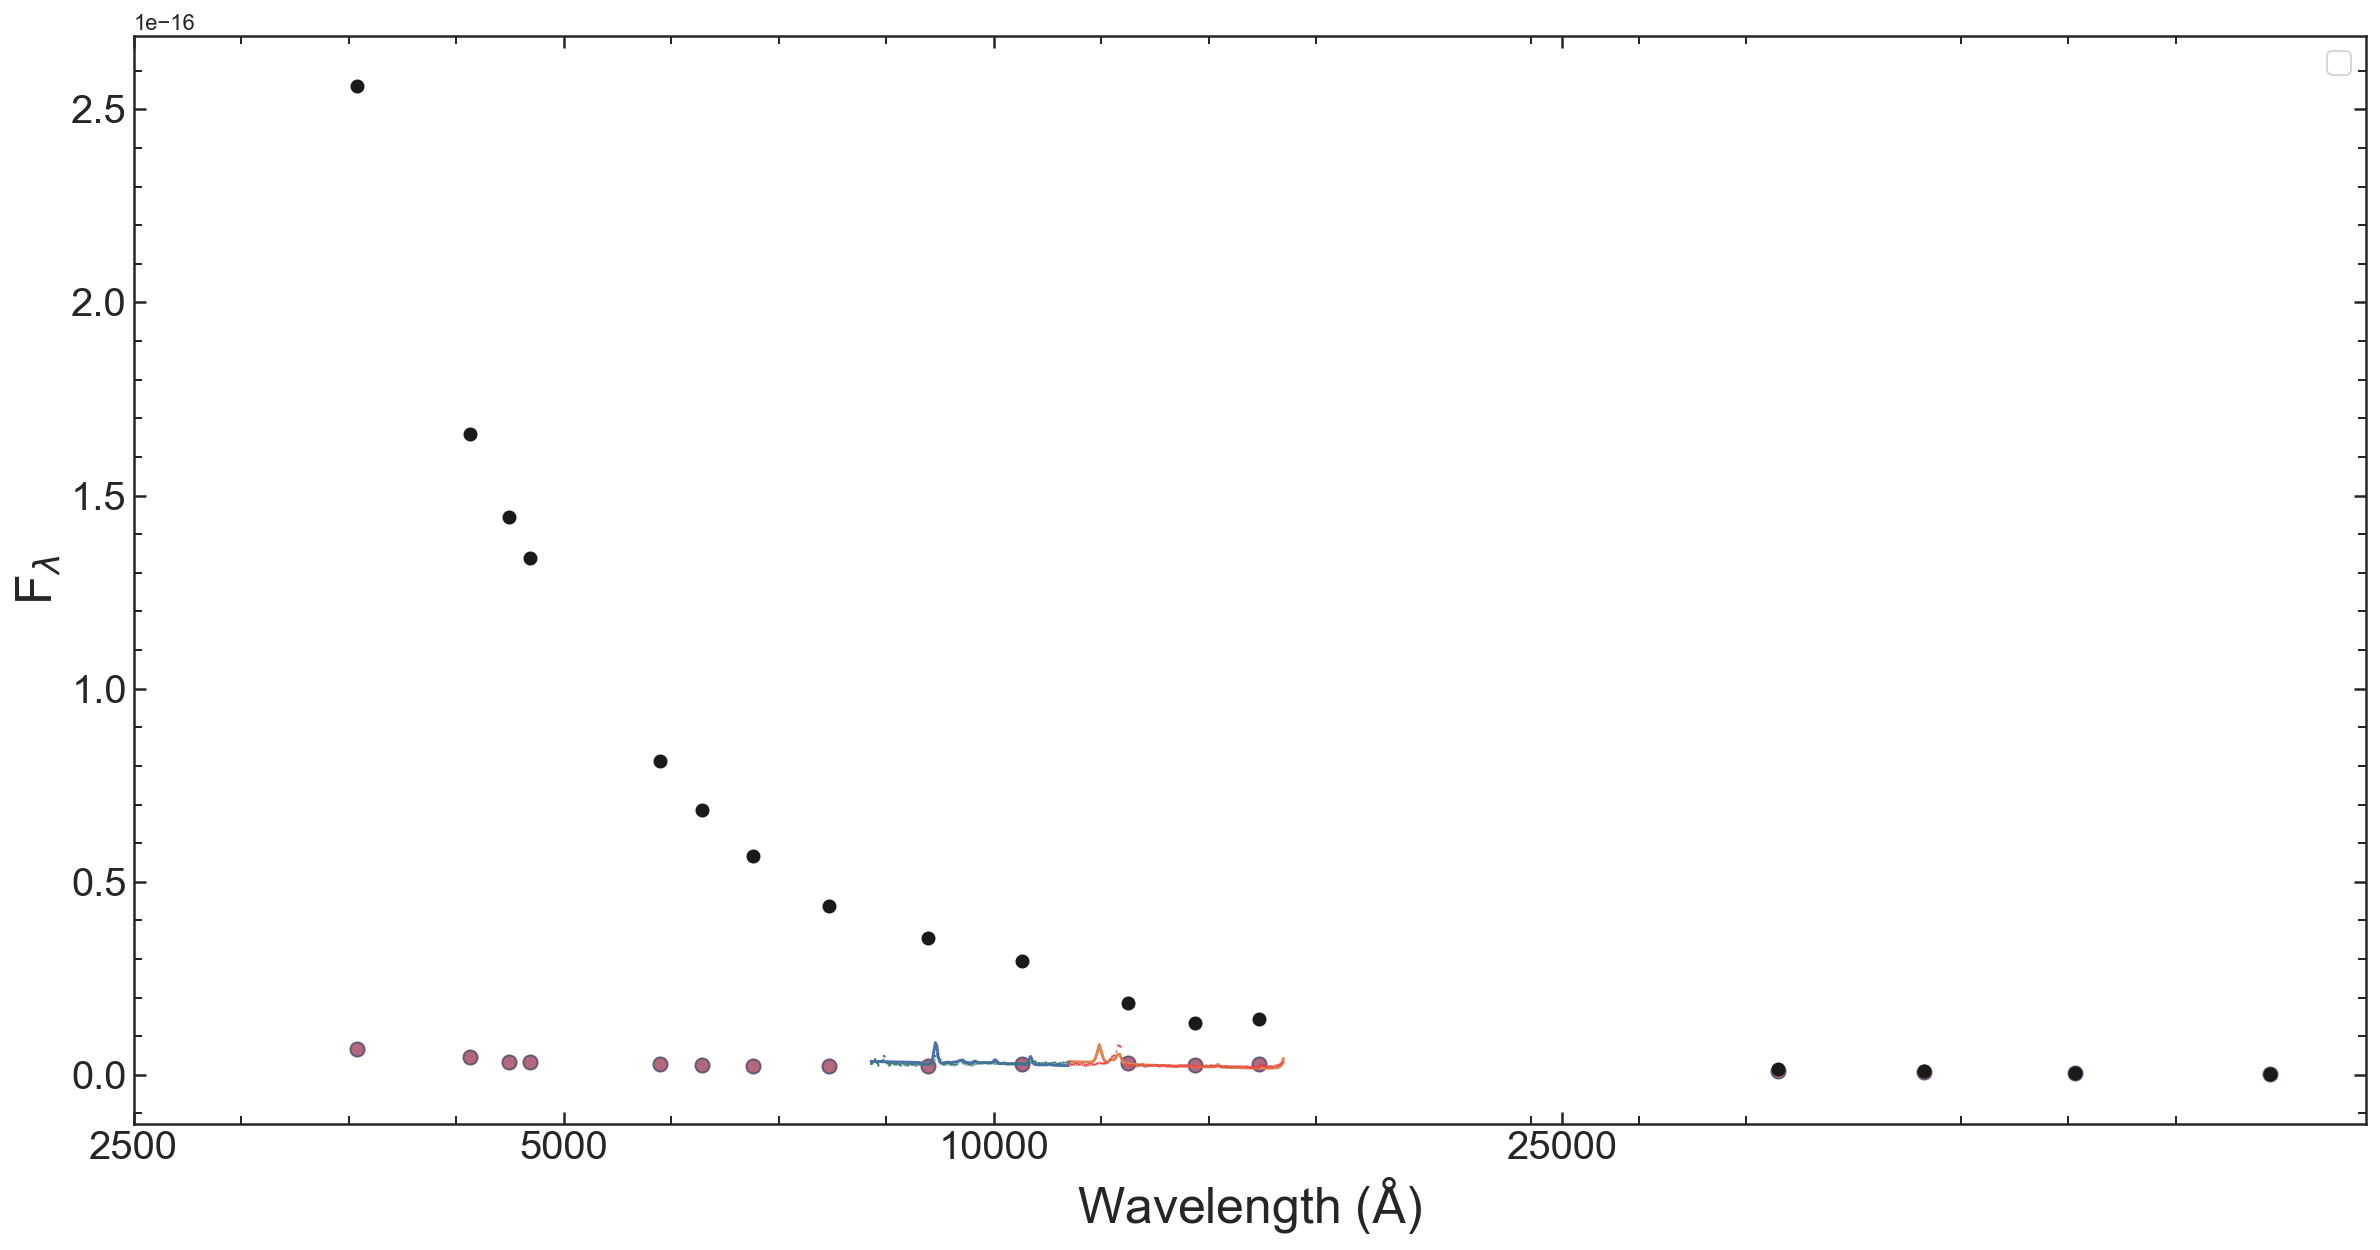

In [46]:
plt.figure(figsize=[20,10])
ax = plt.subplot()
ax.errorbar(np.log10(wvs[0]),flxs[0],errs[0],
        linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.8)
ax.plot(np.log10(wvs[0]), Gmfl[0])

ax.errorbar(np.log10(wvs[1]),flxs[1],errs[1],
        linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.8)
ax.plot(np.log10(wvs[1]), Gmfl[1])

ax.errorbar(np.log10(Gs.Pwv),Gs.Pflx,Gs.Perr,
    linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
         markeredgecolor = '#685877',markeredgewidth = 1)
ax.plot(np.log10(Gs.Pwv), Pmfl,'ko')


ax.set_xticks(np.log10([2500,5000,10000,25000]))
ax.set_xticklabels(np.array([2500,5000,10000,25000]))
ax.legend(fontsize=15, frameon = True, loc = 1)
ax.set_xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
ax.set_ylabel(r'F$_\lambda$', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)

In [47]:
#######set up dynesty########
sampler = dynesty.NestedSampler(Galfit_L, Galfit_prior, ndim = 19,
                                        sample = 'rwalk', bound = 'single',
                                        pool=Pool(processes=4), queue_size=4)


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Boundin

In [ ]:
sampler.run_nested(print_progress=True)

dres = sampler.results

iter: 1840 | bound: 0 | nc: 67 | ncall: 18447 | eff(%):  9.975 | loglstar:   -inf < -87597.238 <    inf | logz: -87607.822 +/-  0.145 | dlogz: 78879.148 >  0.509            

In [ ]:
'done'

# inner outer spectra

In [57]:
def Stack(wv, fl , er):
    
    stwv = [0]
    
    for w in wv:
        if len(w) > len(stwv):
            stwv = w
    
    flxgrid = []
    errgrid = []
    
    for i in range(len(fl)):
        ifl = interp1d(wv[i][~np.isnan(fl[i])], fl[i][~np.isnan(fl[i])], bounds_error=False, fill_value=0)
        ier = interp1d(wv[i][~np.isnan(fl[i])], er[i][~np.isnan(fl[i])], bounds_error=False, fill_value=1E5)
        
        flxgrid.append(ifl(stwv))
        errgrid.append(ier(stwv))
    
    flgrid = np.transpose(flxgrid)
    errgrid = np.transpose(errgrid)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(stwv)])
    for i in range(len(stwv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    ################
    
    return stwv, stack, err

def get_innner_spec(fitsfile, rp =1):
    beam = model.BeamCutout(fits_file=fitsfile)

    clean = beam.grism['SCI'] - beam.contam 
    bg_i = 0.

    ## New weight scheme
    ivar = beam.ivar
    fcontam =0.2
    weight = np.exp(-(fcontam*np.abs(beam.contam)*np.sqrt(ivar)))

    wave, flux, err = beam.beam.trace_extract(clean, r=rp,
                                                ivar=ivar)

    
    flat = beam.flat_flam.reshape(beam.beam.sh_beam)
    wave, fflux, ferr = beam.beam.optimal_extract(flat, ivar=ivar,
                                                  weight=weight)

    ok = beam.beam.sensitivity > 0.1*beam.beam.sensitivity.max()

    wave = wave[ok]
    flux  = (flux/fflux)[ok]*beam.beam.scale
    err   = (err/fflux)[ok]

    okerr = np.isfinite(err)
    
    return wave[okerr], flux[okerr], err[okerr]

def get_outer_spec(fitsfile):
    beam = model.BeamCutout(fits_file=fitsfile)

    clean = beam.grism['SCI'] - beam.contam 
    bg_i = 0.

    ## New weight scheme
    ivar = beam.ivar
    fcontam =0.
    weight = np.exp(-(fcontam*np.abs(beam.contam)*np.sqrt(ivar)))

    wave, flux, err = beam.beam.optimal_extract(clean, 
                                                ivar=ivar,
                                                weight=weight)

    
    flat = beam.flat_flam.reshape(beam.beam.sh_beam)
    wave, fflux, ferr = beam.beam.optimal_extract(flat, ivar=ivar,
                                                  weight=weight)

    ok = beam.beam.sensitivity > 0.1*beam.beam.sensitivity.max()

    wave = wave[ok]
    flux  = (flux/fflux)[ok]*beam.beam.scale
    err   = (err/fflux)[ok]

    okerr = np.isfinite(err)
    
    return wave[okerr], flux[okerr], err[okerr]

# def get_outer_spec(inner_stack, field, galaxy, instr, lim1, lim2):
#     Iw,If,Ie = inner_stack
    
#     W, F, E, FLT, L, C = np.load('../spec_files/{0}_{1}_{2}.npy'.format(field, galaxy, instr))

#     IDX = [U for U in range(len(W)) if  lim1 <= W[U] <= lim2 and F[U]**2 > 0]
    
#     W = W[IDX]
#     F = F[IDX]
#     E = E[IDX]
#     FLT = FLT[IDX]
    
#     iIf = interp1d(Iw,If)(W)
#     iIe = interp1d(Iw,Ie)(W)    
    
#     return W, iIf, iIe, F/FLT - iIf, E/FLT, F/FLT

In [88]:
IWV, IFL, IER = [[],[],[]]
FWV, FFL, FER = [[],[],[]]

for beam in glob('../CLEAR_show_and_tell/*_12078.g102.A.fits'):
    Iw,If,Ie = get_innner_spec(beam, rp=7)
    IWV.append(Iw)
    IFL.append(If)    
    IER.append(Ie)         

    Fw,Ff,Fe = get_outer_spec(beam)
    FWV.append(Fw)
    FFL.append(Ff)    
    FER.append(Fe) 
    
    
IWVs1, IFLs1, IERs1 = Stack(np.array(IWV),np.array(IFL),np.array(IER))
FWVs1, FFLs1, FERs1 = Stack(np.array(FWV),np.array(FFL),np.array(FER))

OFLs1 = interp1d(FWVs1, FFLs1)(IWVs1) - IFLs1
OERs1 = interp1d(FWVs1, FERs1)(IWVs1) / interp1d(FWVs1, FFLs1)(IWVs1) * OFLs1


IFS1 = IFS1 - 0.*OFS1

SCI1 = np.trapz(IFLs1,IWVs1)
SCO1 = np.trapz(OFLs1,IWVs1)


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:652: RuntimeWarning: divide by zero encountered in true_divide
  var = 1./ivar
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:594: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astro

In [95]:
beam = model.BeamCutout(fits_file=glob('../CLEAR_show_and_tell/*_12078.g102.A.fits')[3])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


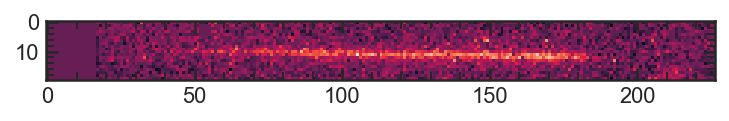

In [96]:
plt.imshow(beam.grism.data['SCI'])

-0.2674637652619936

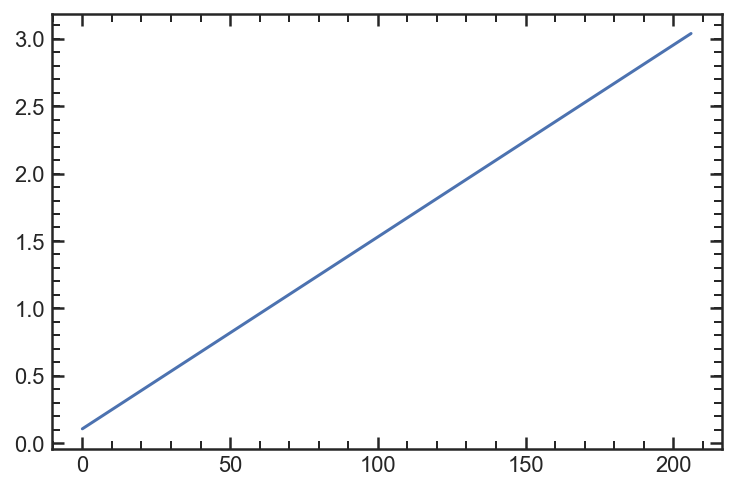

In [105]:
plt.plot(np.arange(len(beam.beam.ytrace_beam)),beam.beam.ytrace_beam)


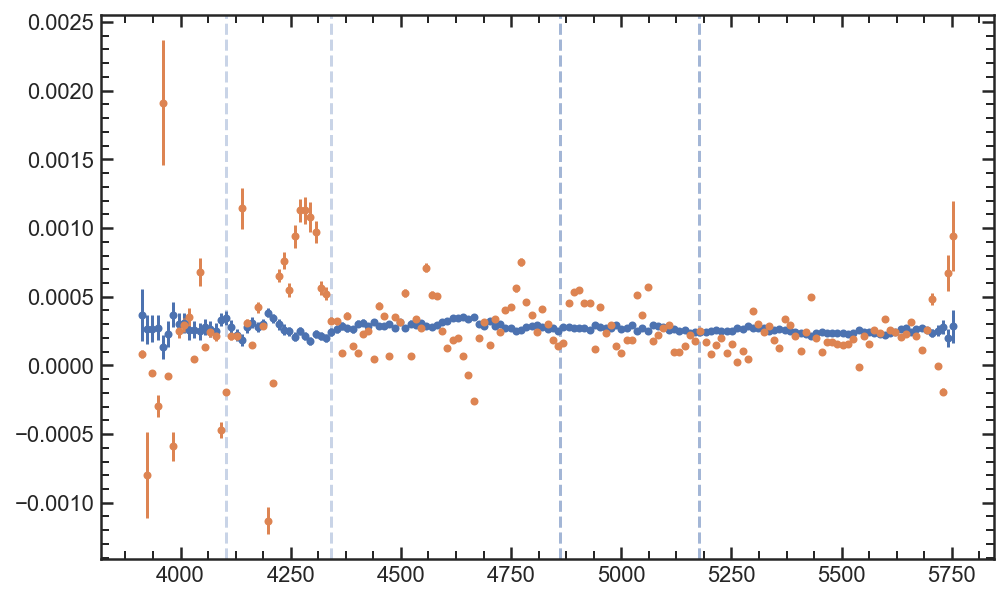

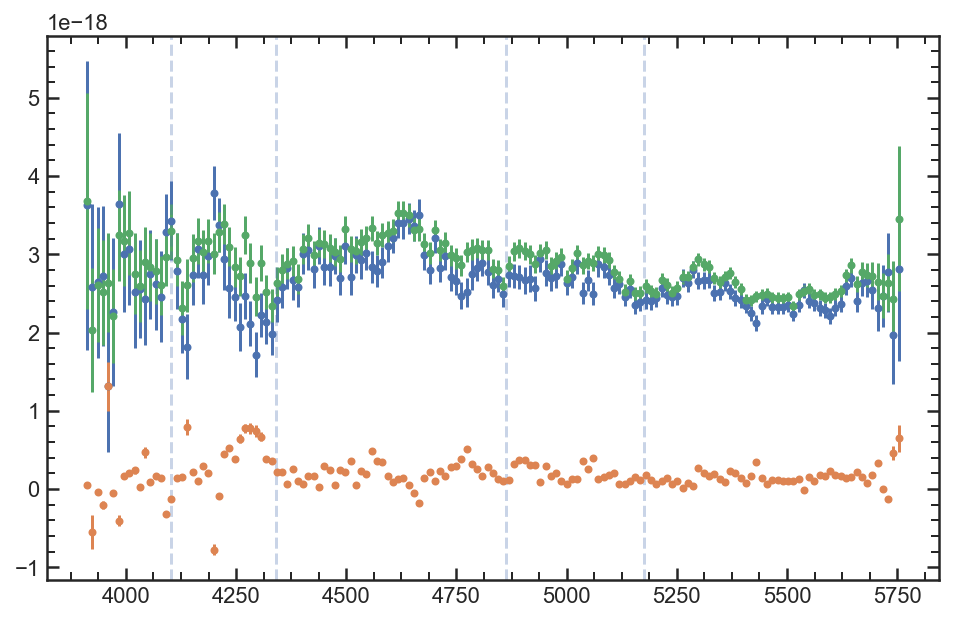

In [89]:
plt.figure(figsize=[8,5])
plt.errorbar(IWVs1/(1+1.0167),IFLs1/SCI1,IERs1/SCI1, linestyle = 'none', ms=3, marker='o')
plt.errorbar(IWVs1/(1+1.0167),OFLs1/SCO1,OERs1/SCO1, linestyle = 'none', ms=3, marker='o')
plt.axvline(4862,linestyle='--', alpha=.3)
plt.axvline(5176,linestyle='--', alpha=.3)
plt.axvline(4102,linestyle='--', alpha=.3)
plt.axvline(4341,linestyle='--', alpha=.3)
plt.axvline(4862,linestyle='--', alpha=.3)
plt.axvline(5176,linestyle='--', alpha=.3)

plt.figure(figsize=[8,5])
plt.errorbar(IWVs1/(1+1.0167), IFLs1, IERs1, linestyle = 'none', ms=3, marker='o')
plt.errorbar(IWVs1/(1+1.0167), OFLs1, OERs1, linestyle = 'none', ms=3, marker='o') 
plt.errorbar(FWVs1/(1+1.0167), FFLs1, FERs1, linestyle = 'none', ms=3, marker='o')
plt.axvline(4102,linestyle='--', alpha=.3)
plt.axvline(4341,linestyle='--', alpha=.3)
plt.axvline(4862,linestyle='--', alpha=.3)
plt.axvline(5176,linestyle='--', alpha=.3)


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 2)

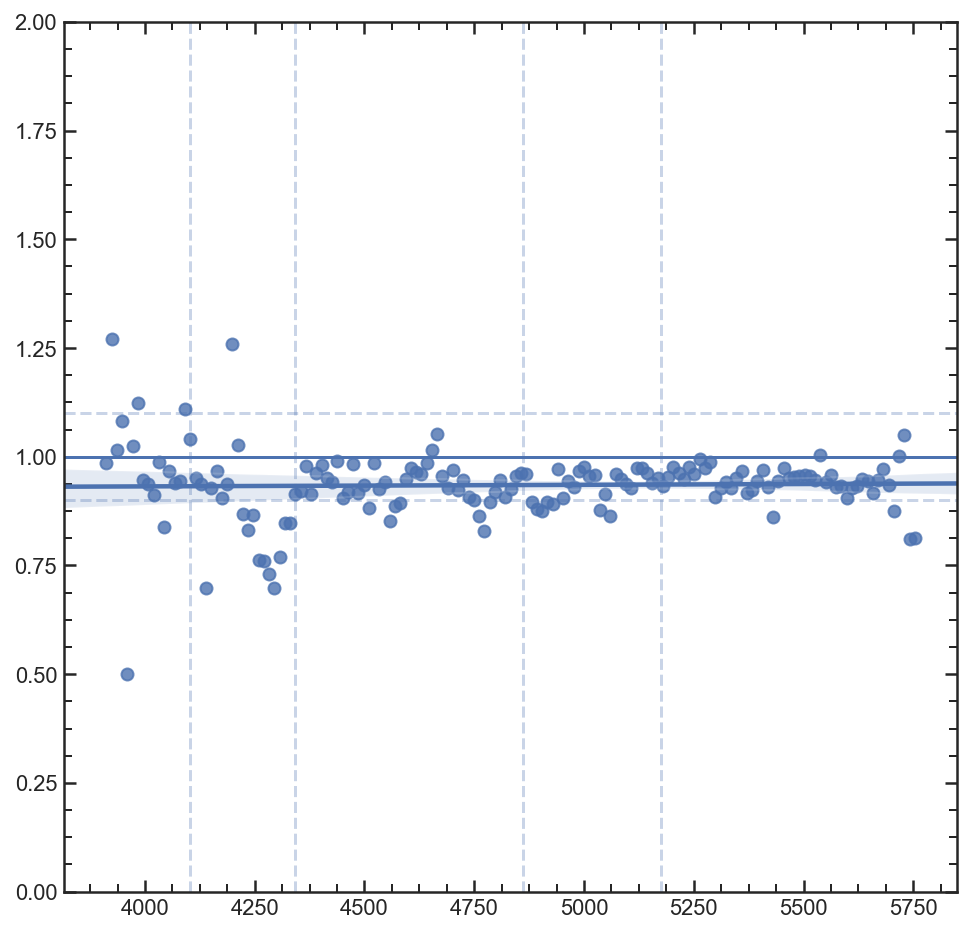

In [86]:
plt.figure(figsize = [8,8])
sea.regplot(IWVs1/(1+1.0167), IFLs1/FFLs1, order =1)
plt.axhline(1)
plt.axhline(0.9,linestyle= '--', alpha=0.3)
plt.axhline(1.1,linestyle= '--', alpha=0.3)

plt.axvline(4102,linestyle='--', alpha=.3)
plt.axvline(4341,linestyle='--', alpha=.3)

plt.axvline(4862,linestyle='--', alpha=.3)
plt.axvline(5176,linestyle='--', alpha=.3)
plt.ylim(0,2)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 2)

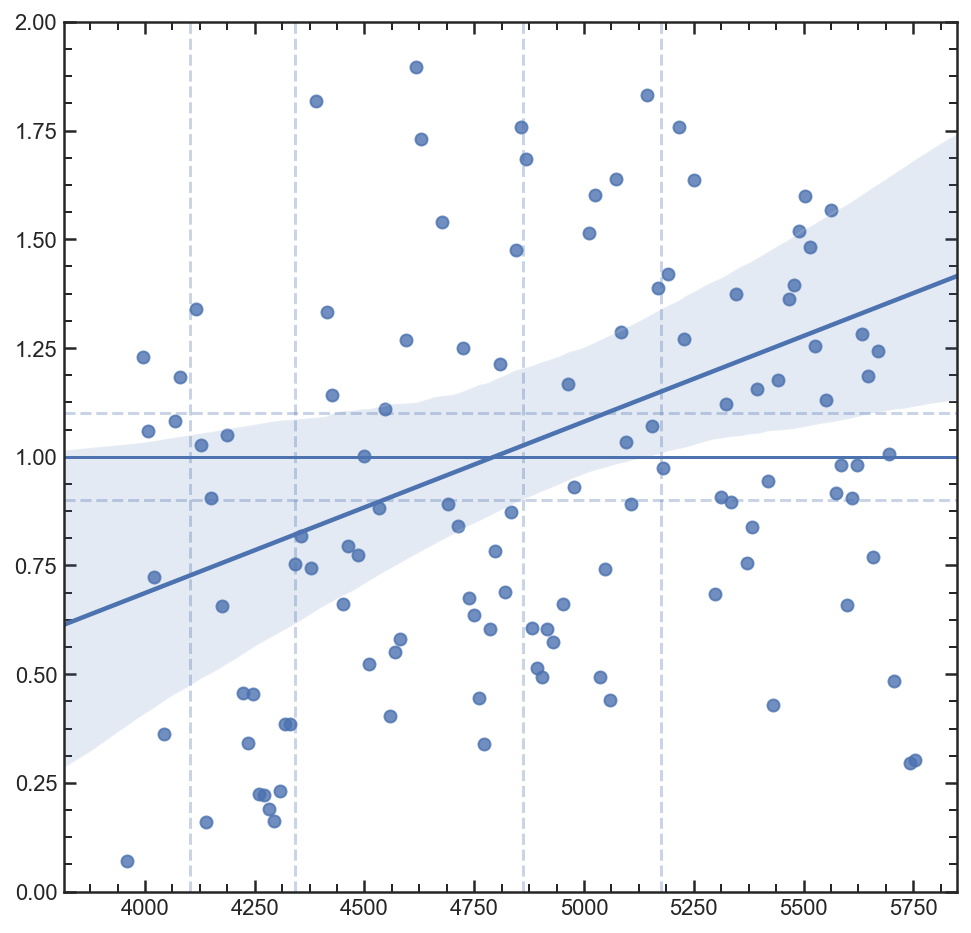

In [85]:
plt.figure(figsize = [8,8])
sea.regplot(IWVs1/(1+1.0167), IFLs1/OFLs1 * SCO1 / SCI1, robust=True)
plt.axhline(1)
plt.axhline(0.9,linestyle= '--', alpha=0.3)
plt.axhline(1.1,linestyle= '--', alpha=0.3)

plt.axvline(4102,linestyle='--', alpha=.3)
plt.axvline(4341,linestyle='--', alpha=.3)

plt.axvline(4862,linestyle='--', alpha=.3)
plt.axvline(5176,linestyle='--', alpha=.3)
plt.ylim(0,2)

In [80]:
IWV, IFL, IER = [[],[],[]]
FWV, FFL, FER = [[],[],[]]

for beam in glob('../CLEAR_show_and_tell/*_39170.g102.A.fits'):
    Iw,If,Ie = get_innner_spec(beam, rp=6)
    IWV.append(Iw)
    IFL.append(If)    
    IER.append(Ie)         

    Fw,Ff,Fe = get_outer_spec(beam)
    FWV.append(Fw)
    FFL.append(Ff)    
    FER.append(Fe) 
    
    
IWVs2, IFLs2, IERs2 = Stack(np.array(IWV),np.array(IFL),np.array(IER))
FWVs2, FFLs2, FERs2 = Stack(np.array(FWV),np.array(FFL),np.array(FER))

OFLs2 = interp1d(FWVs2, FFLs2)(IWVs2) - IFLs2
OERs2 = interp1d(FWVs2, FERs2)(IWVs2) / interp1d(FWVs2, FFLs2)(IWVs2) * OFLs2


# IFS2 = IFS2 - 0.*OFS2

SCI2 = np.trapz(IFLs2,IWVs2)
SCO2 = np.trapz(OFLs2,IWVs2)


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:652: RuntimeWarning: divide by zero encountered in true_divide
  var = 1./ivar
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:594: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astro

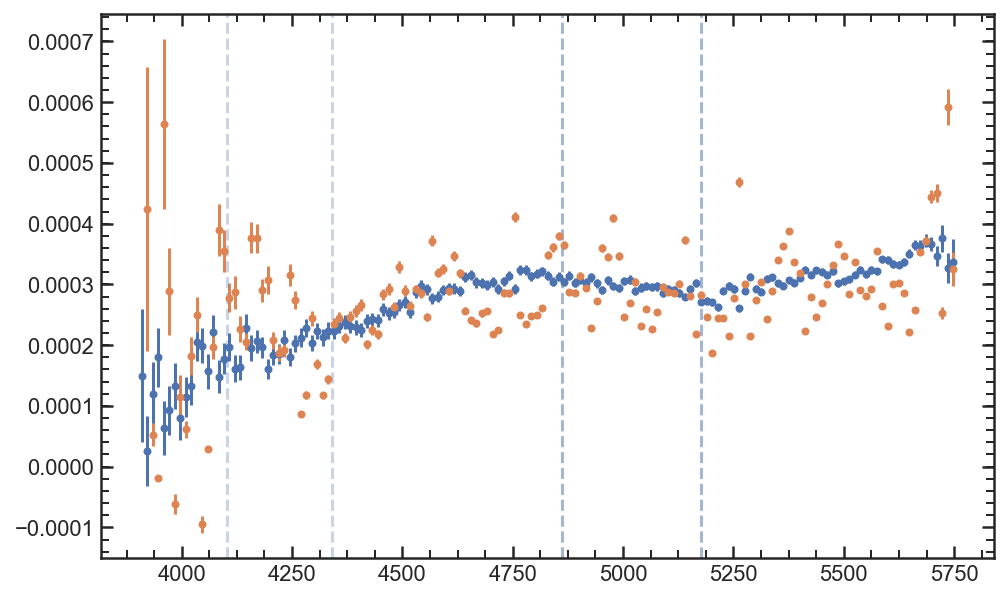

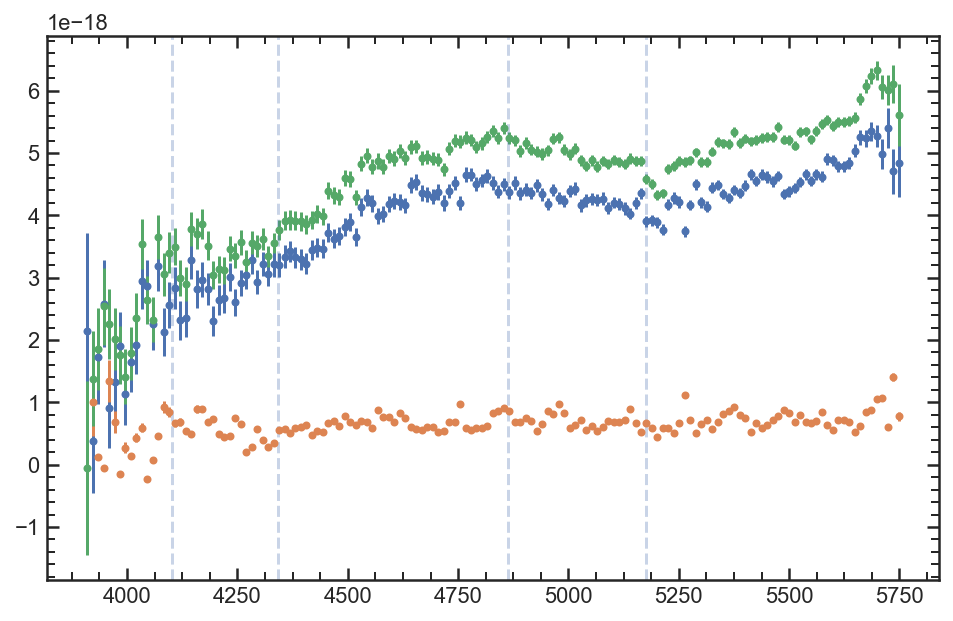

In [81]:
plt.figure(figsize=[8,5])
plt.errorbar(IWVs2/(1+1.018),IFLs2/SCI2,IERs2/SCI2, linestyle = 'none', ms=3, marker='o')
plt.errorbar(IWVs2[1:]/(1+1.018),OFLs2[1:]/SCO2,OERs2[1:]/SCO2, linestyle = 'none', ms=3, marker='o')
plt.axvline(4862,linestyle='--', alpha=.3)
plt.axvline(5176,linestyle='--', alpha=.3)
plt.axvline(4102,linestyle='--', alpha=.3)
plt.axvline(4341,linestyle='--', alpha=.3)
plt.axvline(4862,linestyle='--', alpha=.3)
plt.axvline(5176,linestyle='--', alpha=.3)

plt.figure(figsize=[8,5])
plt.errorbar(IWVs2/(1+1.018), IFLs2, IERs2, linestyle = 'none', ms=3, marker='o')
plt.errorbar(IWVs2[1:]/(1+1.018), OFLs2[1:], OERs2[1:], linestyle = 'none', ms=3, marker='o') 
plt.errorbar(FWVs2/(1+1.018), FFLs2, FERs2, linestyle = 'none', ms=3, marker='o')
plt.axvline(4102,linestyle='--', alpha=.3)
plt.axvline(4341,linestyle='--', alpha=.3)
plt.axvline(4862,linestyle='--', alpha=.3)
plt.axvline(5176,linestyle='--', alpha=.3)


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 2)

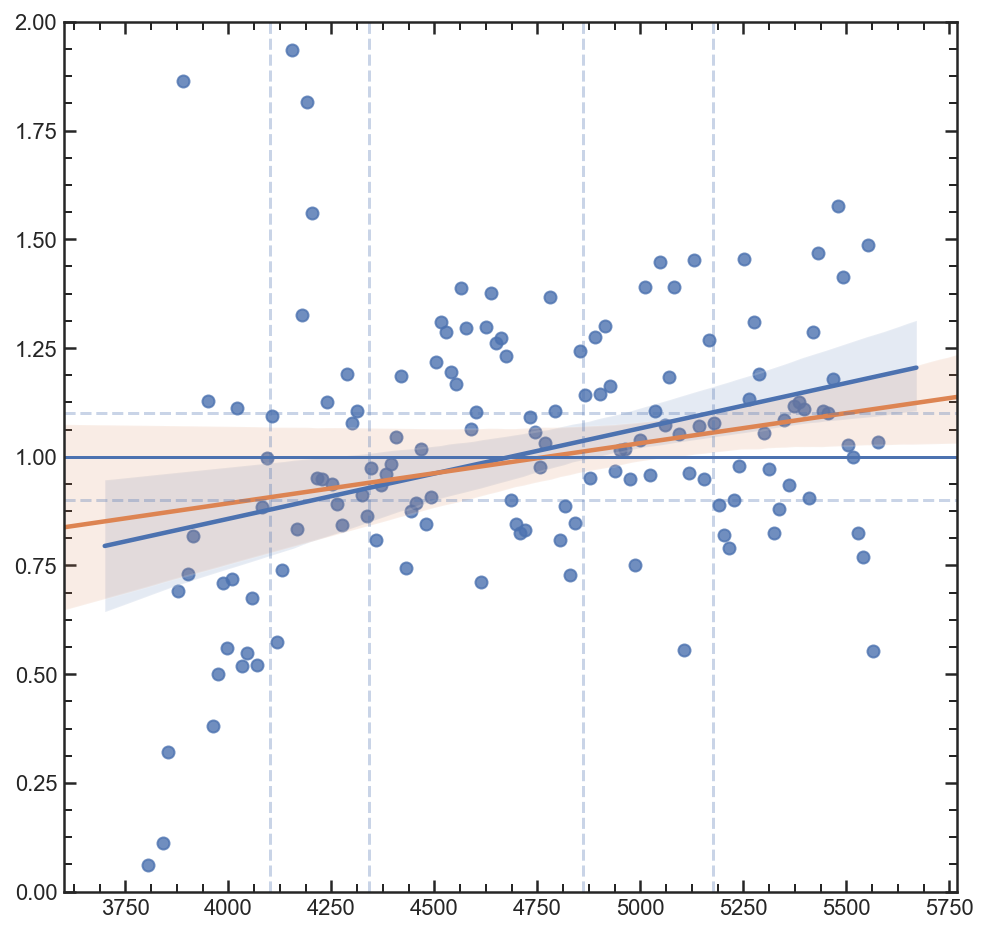

In [82]:
plt.figure(figsize = [8,8])
sea.regplot(IWVs2/(1+1.08), IFLs2/OFLs2 * SCO2 / SCI2, robust=True)
sea.regplot(IWVs1/(1+1.0167), IFLs1/OFLs1 * SCO1 / SCI1, robust=True, scatter = False)

plt.axhline(1)
plt.axhline(0.9,linestyle= '--', alpha=0.3)
plt.axhline(1.1,linestyle= '--', alpha=0.3)

plt.axvline(4102,linestyle='--', alpha=.3)
plt.axvline(4341,linestyle='--', alpha=.3)

plt.axvline(4862,linestyle='--', alpha=.3)
plt.axvline(5176,linestyle='--', alpha=.3)
plt.ylim(0,2)

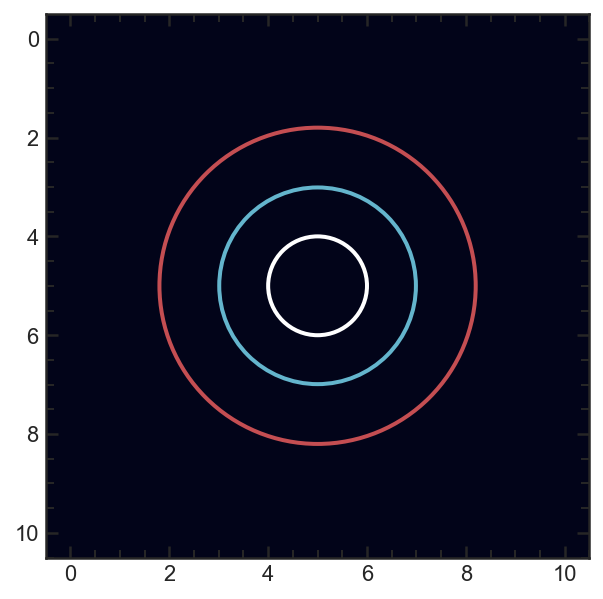

In [82]:
plt.figure(figsize=[5,5])
ax = plt.subplot()
plt.imshow(np.ones([11,11]))
circle1=plt.Circle((5,5),radius=1,ec='w',fc='none', linewidth=2)
circle2=plt.Circle((5,5),radius=3.2,ec='r',fc='none', linewidth=2)
circle3=plt.Circle((5,5),radius=1.99,ec='c',fc='none', linewidth=2)

ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)

In [74]:
mdb = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')

In [178]:
def Stack(wv, fl , er):
    
    stwv = [0]
    
    for w in wv:
        if len(w) > len(stwv):
            stwv = w
    
    flxgrid = []
    errgrid = []
    
    for i in range(len(fl)):
        ifl = interp1d(wv[i][~np.isnan(fl[i])], fl[i][~np.isnan(fl[i])], bounds_error=False, fill_value=0)
        ier = interp1d(wv[i][~np.isnan(fl[i])], er[i][~np.isnan(fl[i])], bounds_error=False, fill_value=1E5)
        
        flxgrid.append(ifl(stwv))
        errgrid.append(ier(stwv))
    
    flgrid = np.transpose(flxgrid)
    errgrid = np.transpose(errgrid)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(stwv)])
    for i in range(len(stwv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    ################
    
    return stwv, stack, err

def get_inner_spec_model(beam, spec2d, rp =1):
    wave, flux, err = beam.beam.trace_extract(spec2d, r=rp,ivar= beam.ivar)

    flat = beam.flat_flam.reshape(beam.beam.sh_beam)
    wave, fflux, ferr = beam.beam.optimal_extract(flat,ivar= beam.ivar)

    ok = beam.beam.sensitivity > 0.1*beam.beam.sensitivity.max()

    wave = wave[ok]
    flux  = (flux/fflux)[ok]*beam.beam.scale
    err   = (err/fflux)[ok]

    okerr = np.isfinite(err)
    
    wave = wave[okerr]
    flux = flux[okerr]
    err = err[okerr]
    
    okerr = err < 2*flux
    
    return wave[okerr], flux[okerr], err[okerr]

In [2]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 4, tau=0.5, dust_type = 1)
wave,flux = sp.get_spectrum(tage=2, peraa=True)

In [289]:
IWV, IFL, IER = [[],[],[]]
FWV, FFL, FER = [[],[],[]]

for fitsfile in glob('../CLEAR_show_and_tell/*_39170.g102.A.fits'):
    beam = model.BeamCutout(fits_file=fitsfile)
    beam.beam.compute_model(spectrum_1d=[wave*(1+1.25),flux])
    
    bnoise = np.random.normal(0,0.044, size = beam.beam.sh_beam)
    scl = Scale_model(beam.grism.data['SCI'], beam.grism.data['ERR'], beam.beam.model)

    
    Iw,If,Ie = get_inner_spec_model(beam, scl*beam.beam.model + bnoise , rp=7)
    if len(Iw) > 2:
        IWV.append(Iw)
        IFL.append(If)    
        IER.append(Ie)         

MWV, MFL, MER = Stack(np.array(IWV),np.array(IFL),np.array(IER))

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_tools.py:179: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(((D * M) / sig ** 2)) / np.sum((M ** 2 / sig ** 2))
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_tools.py:179: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(((D * M) / sig ** 2)) / np.sum((M ** 2 / sig ** 2))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:652: RuntimeWarning: divide by zero encountered in true_divide
  var = 1./ivar
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:54

In [288]:
IWV, IFL, IER = [[],[],[]]
FWV, FFL, FER = [[],[],[]]

for fitsfile in glob('../CLEAR_show_and_tell/*_39170.g102.A.fits'):
    beam = model.BeamCutout(fits_file=fitsfile)
    beam.beam.compute_model(spectrum_1d=[wave*(1+1.25),flux])
    
    bnoise = np.random.normal(0,0.044, size = beam.beam.sh_beam)
    scl = Scale_model(beam.grism.data['SCI'], beam.grism.data['ERR'], beam.beam.model)

    
    Iw,If,Ie = get_inner_spec_model(beam, scl*beam.beam.model + bnoise , rp=7)
    if len(Iw) > 2:
        IWV.append(Iw)
        IFL.append(If)    
        IER.append(Ie)         

MWV2, MFL2, MER2 = Stack(np.array(IWV),np.array(IFL),np.array(IER))

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_tools.py:179: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(((D * M) / sig ** 2)) / np.sum((M ** 2 / sig ** 2))
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_tools.py:179: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(((D * M) / sig ** 2)) / np.sum((M ** 2 / sig ** 2))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:652: RuntimeWarning: divide by zero encountered in true_divide
  var = 1./ivar
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:54

In [260]:
# w,f,e =beam.beam.optimal_extract(beam.beam.model, bin=0)
w,f,e =beam.beam.trace_extract(beam.beam.model*scl + bnoise, r=7,bin=0, ivar=beam.ivar)
mw,mf,me =beam.beam.trace_extract(beam.beam.model*scl, r=7,bin=0, ivar=beam.ivar)

scf = np.trapz(f,w)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:652: RuntimeWarning: divide by zero encountered in true_divide
  var = 1./ivar


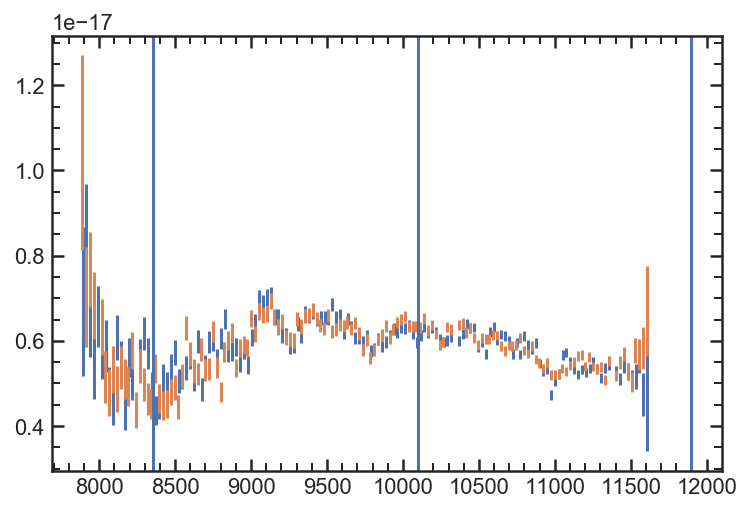

In [290]:
plt.errorbar(MWV, MFL, MER, linestyle = 'none')
plt.errorbar(MWV2, MFL2, MER2, linestyle = 'none')

# plt.plot(mw[IDX],mf[IDX]/ fflux[IDX]* 2.1)
plt.axvline(8357)
plt.axvline(10101)
plt.axvline(11897)

In [291]:
IDX = [U for U in range(len(MWV)) if 8400 < MWV[U] < 11000]

MWV = MWV[IDX]
MFL = MFL[IDX]
iMFL2 = interp1d(MWV2,MFL2)(MWV)

scl = np.trapz(MFL, MWV)
scl2 =np.trapz(iMFL2, MWV)


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


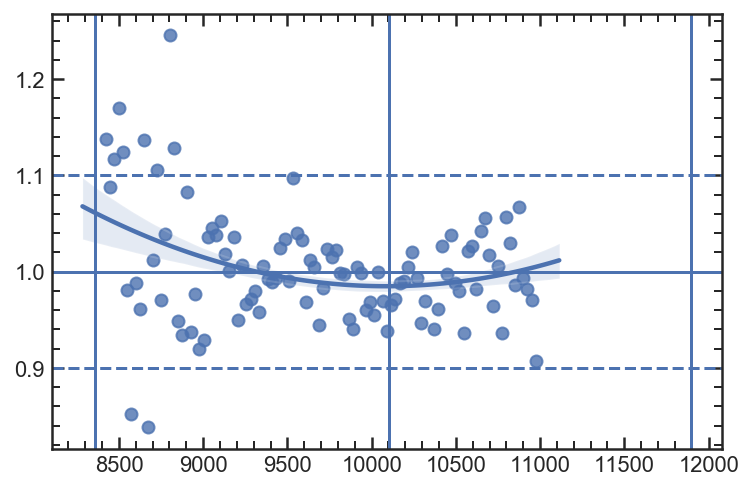

In [293]:
sea.regplot(MWV, MFL/iMFL2 * scl2 / scl, order = 2 , ci=68)
plt.axhline(1)
plt.axhline(1.1, linestyle = '--')
plt.axhline(0.9, linestyle = '--')


plt.axvline(8357)
plt.axvline(10101)
plt.axvline(11897)

In [117]:
def Scale_model(D, sig, M):
    w = 1/sig ** 2
    
    T1 = (D * M * w)
    T2 = (M ** 2 * w)
    
    infmask = np.isinf(T1)
    T1[infmask] = 0

    nanmask = np.isnan(T1)
    T1[nanmask] = 0 

    infmask = np.isinf(T2)
    T2[infmask] = 0

    nanmask = np.isnan(T2)
    T2[nanmask] = 0 
    
    return np.sum(T1) / np.sum(T2)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


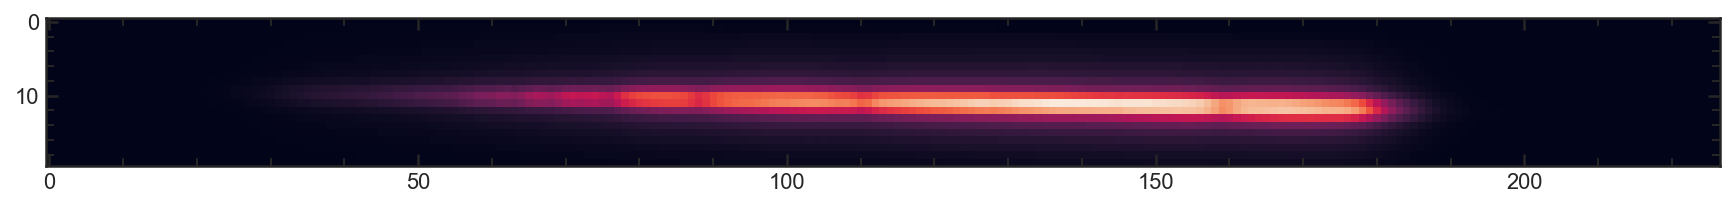

In [118]:
scl = Scale_model(beam.grism.data['SCI'], beam.grism.data['ERR'], beam.beam.model)


plt.figure(figsize=[15,5])
ax = plt.subplot()
plt.imshow(beam.beam.model*scl)


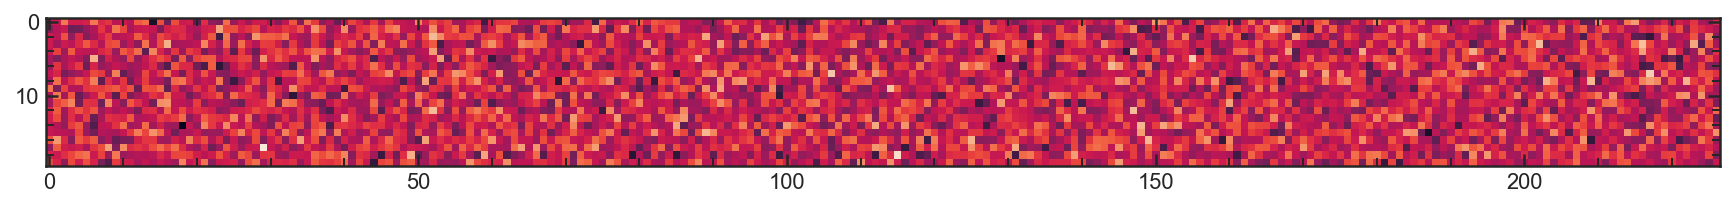

In [149]:
bnoise = np.random.normal(0,0.044, size = beam.beam.sh_beam)

plt.figure(figsize=[15,5])
ax = plt.subplot()
plt.imshow(bnoise)

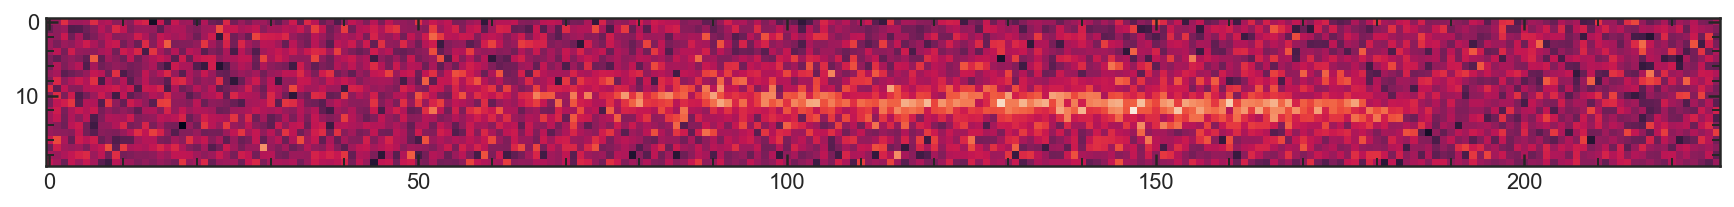

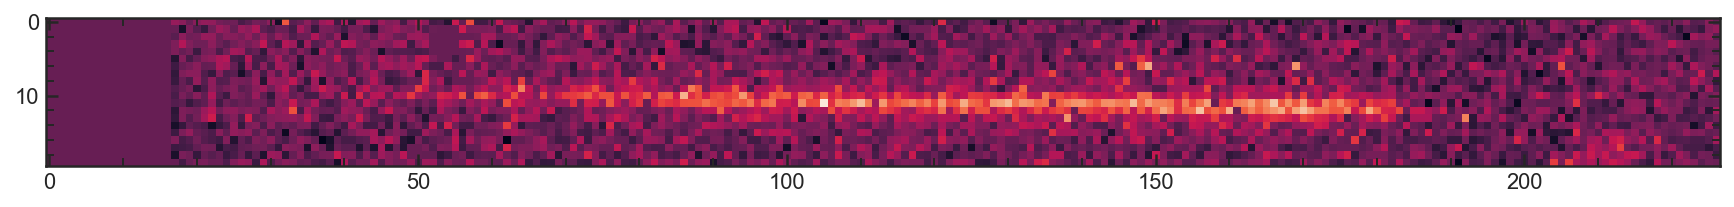

In [150]:
plt.figure(figsize=[15,5])
ax = plt.subplot()
plt.imshow(beam.beam.model*scl + bnoise)

plt.figure(figsize=[15,5])
ax = plt.subplot()
plt.imshow(beam.grism.data['SCI'])

In [140]:
def Trace_mask(beam, r):
    
    dy0 = 0
    modelf = np.zeros(np.product(beam.beam.sh_beam), dtype=np.float)
    model = modelf.reshape(beam.beam.sh_beam)
    dy = np.cast[int](np.round(beam.beam.ytrace+dy0))
    aper = np.zeros_like(model)
    y0 = beam.beam.sh_beam[0] // 2
    for d in range(-r, r+1):
        for i in range(beam.beam.sh_beam[1]):
            aper[y0+d+dy[i]-1,i] = 1

    masked_beam = np.zeros_like(beam.beam.model)

    for i in range(len(masked_beam)):
        for ii in range(len(masked_beam.T)):
            if aper[i][ii] == 1:
                masked_beam[i][ii] = beam.grism.data['SCI'][i][ii]
        
    return masked_beam

([<matplotlib.axis.XTick at 0x1a8c985128>,
 <a list of 7 Text xticklabel objects>)

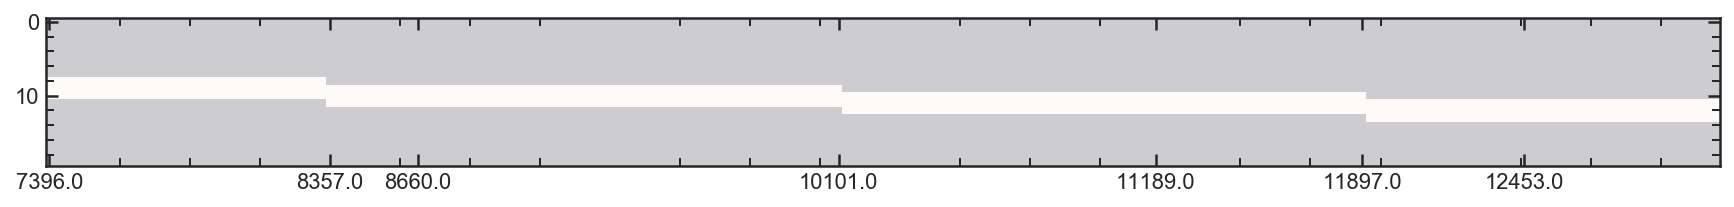

In [227]:
mbeam = Trace_mask(beam, 2)

plt.figure(figsize=[15,5])
ax = plt.subplot()
# plt.imshow(mbeam)
plt.imshow(aper, alpha = .2)
plt.xticks([0,38,50,107,150,178,200],
           np.round(ilam([0,38,50,107,150,178,200])))

In [209]:
ilam = interp1d(np.arange(len(beam.beam.lam_beam)),beam.beam.lam_beam)